# Outlier detection using UMAP

While an earlier tutorial looked at using [UMAP for clustering](https://umap-learn.readthedocs.io/en/latest/clustering.html), it can also be used for outlier detection, providing that some care is taken. This tutorial will look at how to use UMAP in this manner, and what to look out for, by finding anomalous digits in the MNIST handwritten digits dataset. To start with let's load the relevant libraries:

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.neighbors
import umap
import umap.plot
import matplotlib.pyplot as plt
%matplotlib inline

/Users/leland/anaconda3/envs/umap_0.4dev/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/leland/anaconda3/envs/umap_0.4dev/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


With this in hand, let's grab the MNIST digits dataset from the internet, using the new ``fetch_ml`` loader in sklearn. 

In [2]:
data, labels = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

Before we get started we should try looking for outliers in terms of the native 784 dimensional space that MNIST digits live in. To do this we will make use of the [Local Outlier Factor (LOF)](https://en.wikipedia.org/wiki/Local_outlier_factor) method for determining outliers since sklearn has an easy to use implementation. The essential intuition of LOF is to look for points that have a (locally approximated) density that differs significantly from the average density of their neighbors. In our case the actual details are not so important -- it is enough to know that the algorithm is reasonably robust and effective on vector space data. We can apply it using the ``fit_predict`` method of the sklearn class. The LOF class take a parameter ``contamination`` which specifies the percentage of data that the user expects to be noise. For this use case we will set it to 0.001428 since, given the 70,000 samples in MNIST, this will result in 100 outliers, which we can then look at in more detail.

In [3]:
%%time
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.001428).fit_predict(data)

CPU times: user 1h 29min 10s, sys: 12.4 s, total: 1h 29min 22s
Wall time: 1h 29min 53s


It is worth noting how long that took. Over an hour and a half! Why did it take so long? Because LOF requires a notion of density, which in turn relies on a nearest neighbor type computation -- which is expensive in sklearn for high dimensional data. This alone is potentially a reason to look at reducing the dimension of the data -- it makes it more amenable to existing techniques like LOF.

Now that we have a set of outlier scores we can find the actual outlying digit images -- these are the ones with scores equal to -1. Let's extract out that data, and check that we got 100 different digit images.

In [4]:
outlying_digits = data[outlier_scores == -1]
outlying_digits.shape

(100, 784)

Now that we have the outlying digit images the first question we should be asking is "what do they look like?". Fortunately for us we can convert the 784 dimensional vectors back into image and plot them, making it easier to look at. Since we extracted the 100 most outlying digit images we can just display a 10x10 grid of them.

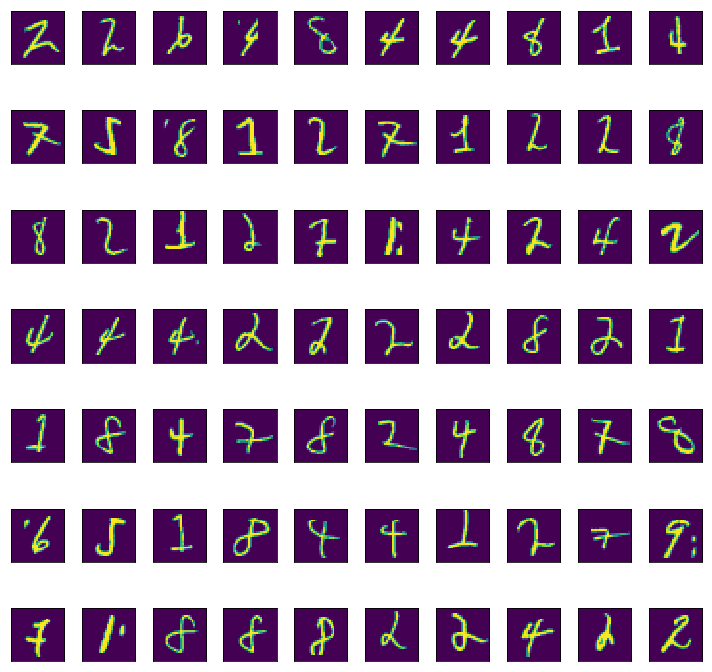

In [5]:
fig, axes = plt.subplots(7, 10, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(outlying_digits[i].reshape((28,28)))
    plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()

These do certainly look like somewhat strange looking handwritten digits, so our outlier detection seems to be working to some extent.

Now let's try a naive approach using UMAP and see how far that gets us. First let's just apply UMAP directly with default parameters to the MNIST data.

In [6]:
mapper = umap.UMAP().fit(data)

Now we can see what we got using the new plotting tools in umap.plot.

/Users/leland/anaconda3/envs/umap_0.4dev/lib/python3.7/site-packages/datashader/utils.py:348: FutureWarning: `Series.cat.categorical` has been deprecated. Use the attributes on 'Series.cat' directly instead.
  ordered=col.cat.categorical.ordered)


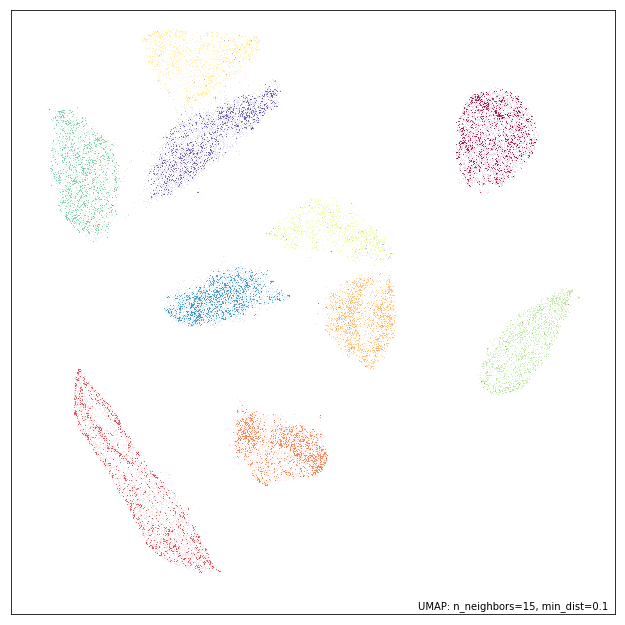

In [7]:
umap.plot.points(mapper, labels=labels)

That looks like what we have come to expect from a UMAP embedding of MNIST. The question is have we managed to preserve outliers well enough that LOF can still find the bizarre digit images, or has the embedding lost that information and contracted the outliers into the individual digit clusters? We can simply apply LOF to the embedding and see what that returns.

In [8]:
%%time
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.001428).fit_predict(mapper.embedding_)

This was obviously much faster since we are operating in a much lower dimensional space that is more amenable to the spatial indexing methods that sklearn uses to find nearest neighbors. As before we extract the outlying digit images, and verify that we got 100 of them,

In [9]:
outlying_digits = data[outlier_scores == -1]
outlying_digits.shape

(100, 784)

Now we need to plot the outlying digit images to see what kinds of digit images this approach found to be particularly strange.

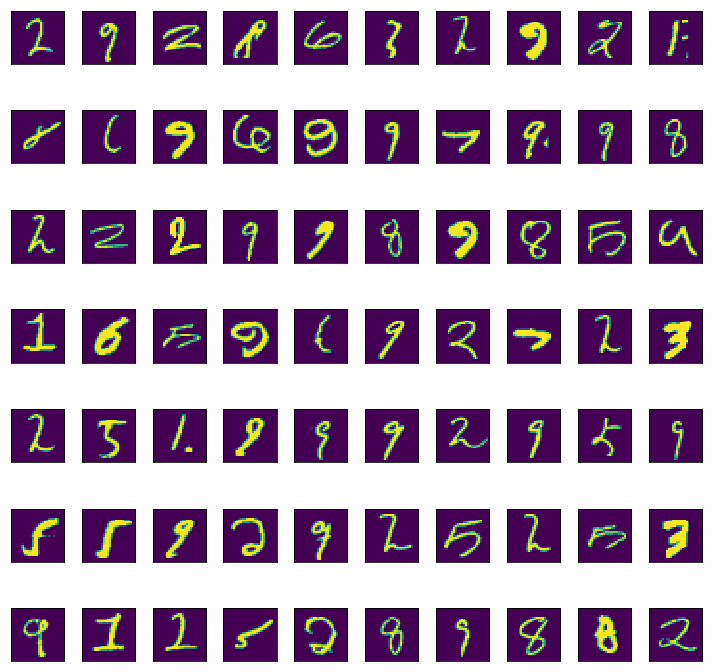

In [10]:
fig, axes = plt.subplots(7, 10, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(outlying_digits[i].reshape((28,28)))
    plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()

In many way this looks to be a *better* result than the original LOF in the high dimensional space. While the digit images that the high dimensional LOF found to be strange were indeed somewhat odd looking, many of these digit images are considerably stranger -- significantly odd line thickness, warped shapes, and images that are hard to even recognise as digits. This helps to demonstrate a certain amount of confirmation bias when examining outliers: since we expect tings tagged as outliers to be strange we tend to find aspects of them that justify that classification, potentially unaware of how much stranger some of the data may in fact be. This should make us wary of even this outlier set: what else might lurk in the dataset?

We can, in fact, potentially improve on this result by tuning the UMAP embedding a little for the task of finding outliers. When UMAP combines together the different local simplicial sets (see [How UMAP Works]() for more details) the standard approach uses a union, but we could instead take an intersection. An intersection ensures that outliers remain disconnected, which is certainly beneficial when seeking to find outliers. A downside of the intersection is that it tends to break up the resulting simplicial set into many disconnected components and a lot of the more non-local and global structure is lost, resulting in a lot lower quality of embedding. We can, however, interpolate between the union and intersection. In UMAP this is given by the ``set_op_mix_ratio``, where a value of 0.0 represents an intersection, and a value of 1.0 represents a union (the default value is 1.0). By setting this to a lower value, say 0.25, we can encourage the embedding to do a better job of preserving outliers as outlying, while still retaining the benefits of a union operation.

In [11]:
mapper = umap.UMAP(set_op_mix_ratio=0.25).fit(data)

/Users/leland/anaconda3/envs/umap_0.4dev/lib/python3.7/site-packages/datashader/utils.py:348: FutureWarning: `Series.cat.categorical` has been deprecated. Use the attributes on 'Series.cat' directly instead.
  ordered=col.cat.categorical.ordered)


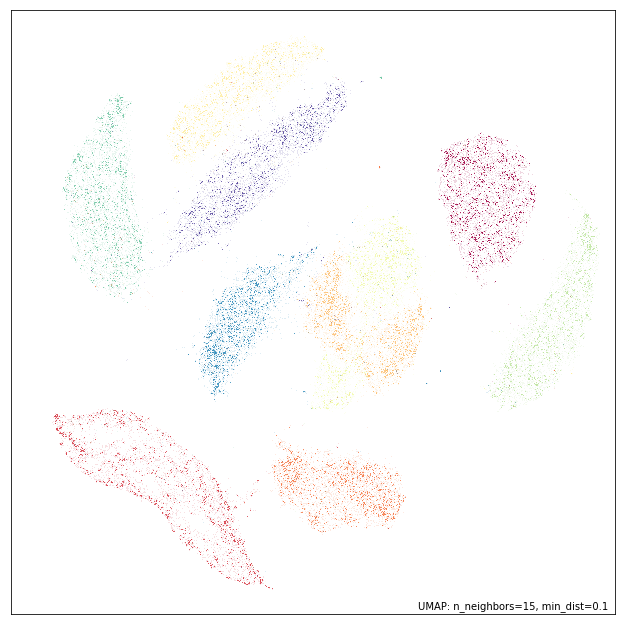

In [12]:
umap.plot.points(mapper, labels=labels)

As you can see the embedding is not as well structured overall as when we had a ``set_op_mix_ratio`` of 1.0, but we have potentially done a better job of ensuring that outliers remain outlying. We can test that hypothesis by running LOF on this embedding and looking at the resulting digit images we get out. Ideally we should expect to find some potentially even stranger results.

In [13]:
%%time
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.001428).fit_predict(mapper.embedding_)

In [14]:
outlying_digits = data[outlier_scores == -1]
outlying_digits.shape

(100, 784)

We have the expected 100 most outlying digit images, so let's visualise the results and see if they really are particularly strange.

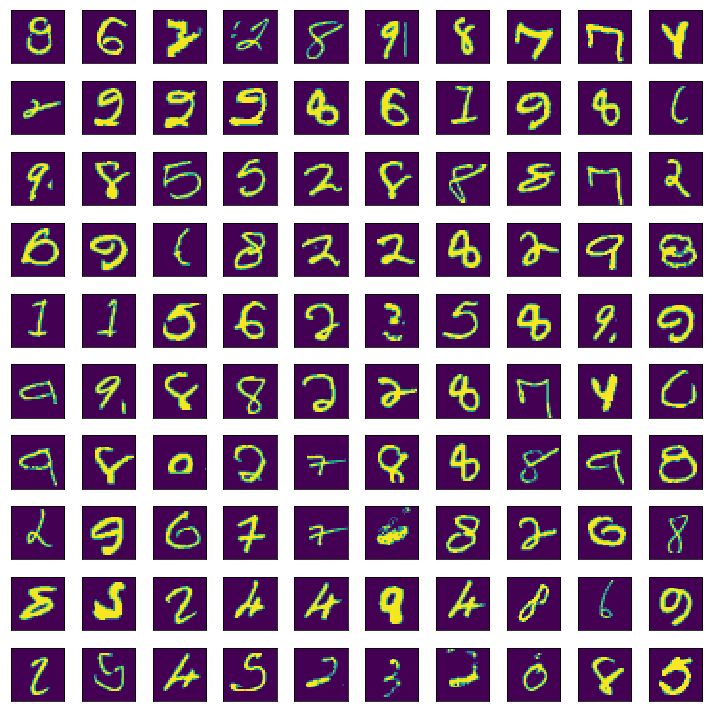

In [15]:
fig, axes = plt.subplots(10, 10, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(outlying_digits[i].reshape((28,28)))
    plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()

Here we see that the line thickness variation (particularly "fat" digits, or particularly "fine" lines) that the original embedding helped surface come through even more strongly here. We also see a number of clearly corrupted images with extra lines, dots, or strange blurring occurring.

So, in summary, using UMAP to reduce dimension prior to running classical outlier detection methods such as LOF can improve both the speed with which the algorithm runs, and the quality of results the outlier detection can find. Furthermore we have introduced the ``set_op_mix_ratio`` parameter, and explained how it can be used to potentially improve the performance of outlier detection approaches applied to UMAP embeddings.